In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

As there are features that have more missing than known values,
it would be better to drop their coloumns opposed to imputing them.

In [5]:
df.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)

In [6]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodD

## Data visualisation

In [7]:
# Separate numerical features
df_num = df.select_dtypes(include = ['int64', 'float64'])
df_num

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,62.0,7917,6,5,1999,2000,0.0,0,...,0,40,0,0,0,0,0,8,2007,175000
1456,1457,20,85.0,13175,6,6,1978,1988,119.0,790,...,349,0,0,0,0,0,0,2,2010,210000
1457,1458,70,66.0,9042,7,9,1941,2006,0.0,275,...,0,60,0,0,0,0,2500,5,2010,266500
1458,1459,20,68.0,9717,5,6,1950,1996,0.0,49,...,366,0,112,0,0,0,0,4,2010,142125


array([[<Axes: title={'center': 'Id'}>,
        <Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>],
       [<Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>],
       [<Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>],
       [<Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,

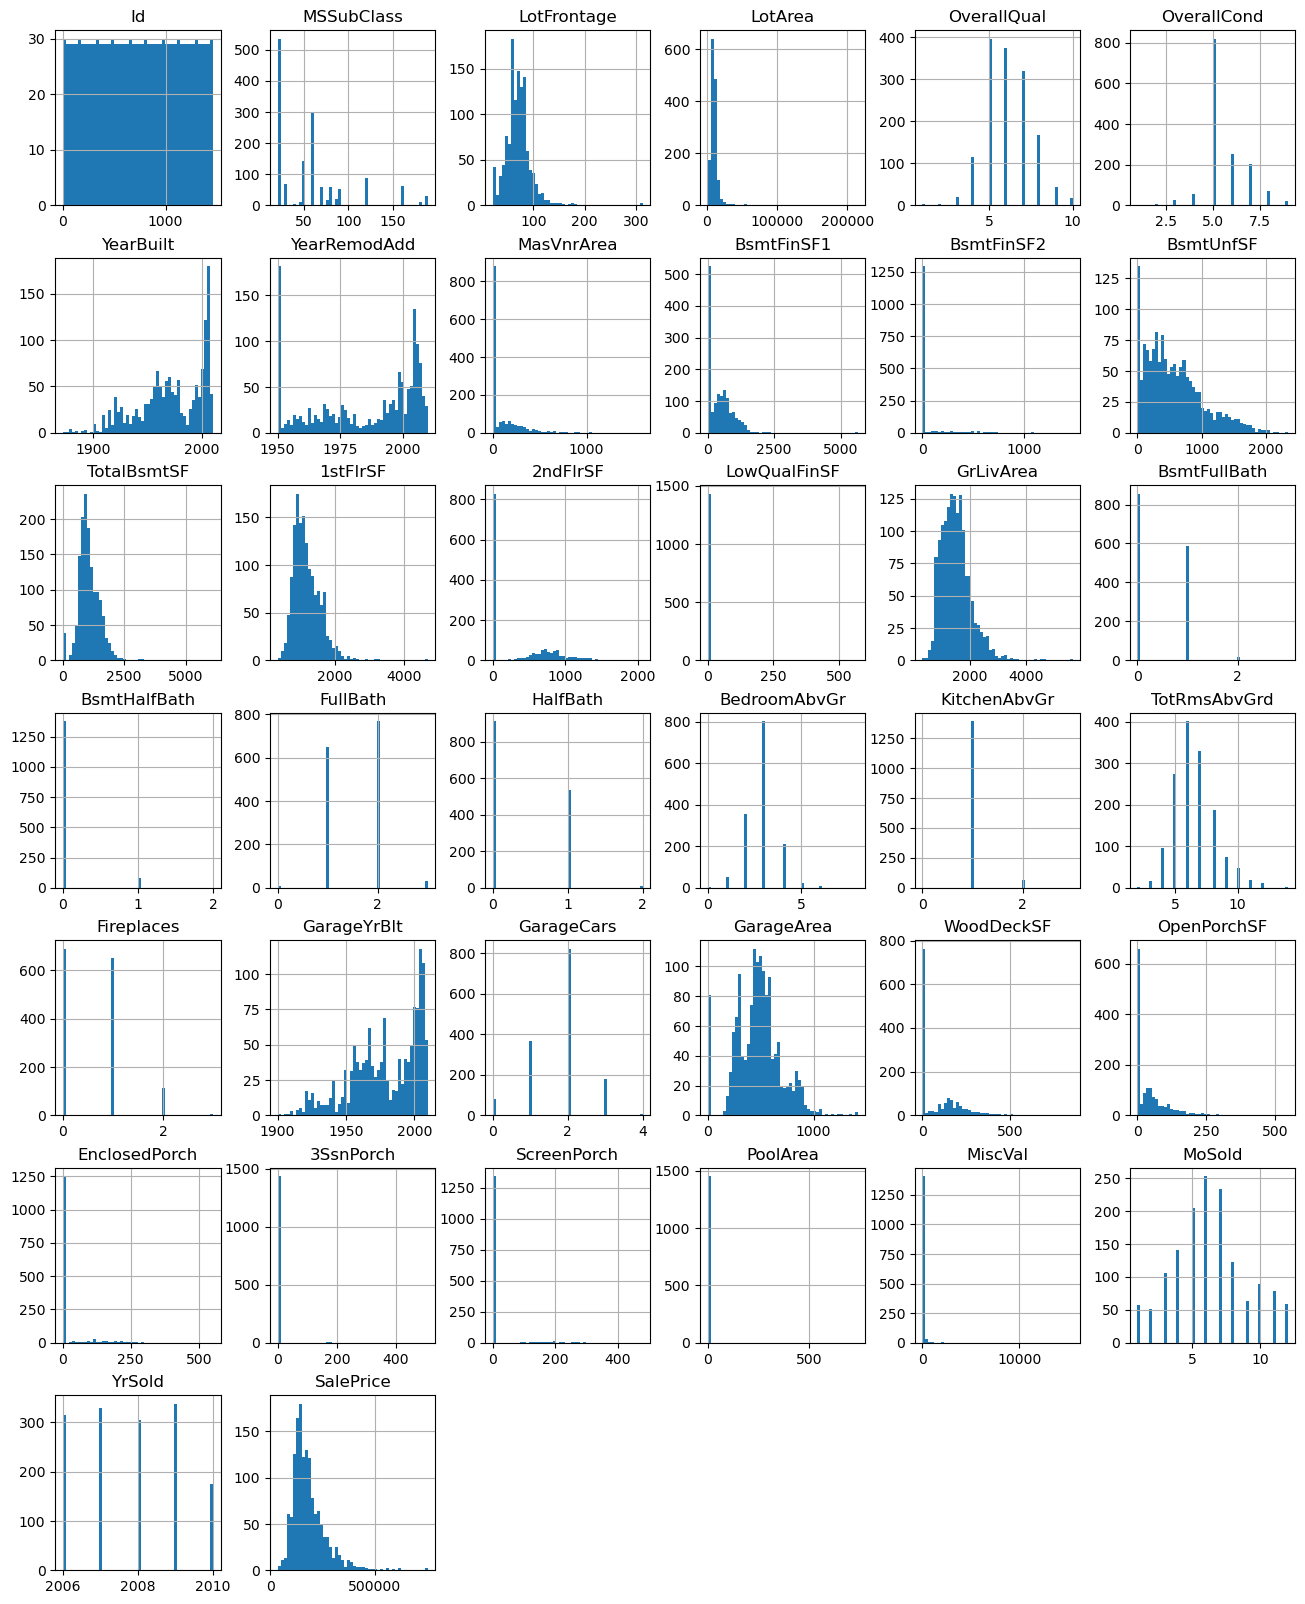

In [8]:
# Create distribultions for the numerical features
df_num.hist(figsize = (16, 20), bins=50)

# Prepare the data by:
* Imputing missing values, 
* Encode the categorical values

In [9]:
# Separate the categorical and numerical columns with their column labels
df_cat = df.select_dtypes(include = ['object']).columns
df_num = df.select_dtypes(include = ['int64', 'float64']).columns

In [10]:
# Define transformers for numerical features using a pipeline
num_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'mean')),
    ('scaler', StandardScaler()) # data is on different scales so I scale it down
])

cat_transformer = Pipeline(steps = [
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [11]:
# Drop the target feature (SalePrice) from the numerical data
df_num = df_num.drop('SalePrice')

# Bundle the preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
transformers = [
    ('num', num_transformer, df_num),
    ('cat', cat_transformer, df_cat)
])

# Fit preprocessor to dataset
X = df.drop('SalePrice', axis=1) 
y = np.log(df['SalePrice']) # Apply log normalization to dependant variable
# X doesnt need to be normalized as it was standardized in the pipeline.
X_preprocessed = preprocessor.fit_transform(X)

In [12]:
# Split training data into training and validation splits
X_train, X_valid, y_train, y_valid = train_test_split(X_preprocessed, y, test_size=0.2, random_state=0)

# Define the regression models
models = {
    'LinearRegression': LinearRegression(),
    'XGBoost': XGBRegressor(random_state=0),
    'RandomForest': RandomForestRegressor(random_state=0)
}
# Define hyperparameter grids for each model
parameters = {
    'LinearRegression': {},
    'RandomForest': {
        'n_estimators': [200, 400, 700],
        'max_depth': [None, 10, 30],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [200, 400, 700],
        'learning_rate': [0.01, 0.05, 0.2],
        'max_depth': [2, 5, 9]
    }
}
# Cross validation over 4 folds
cv = KFold(n_splits=3, shuffle=True, random_state=0)

# Train and tune the models
grids = {}
for model_name, model in models.items():
    grids[model_name] = GridSearchCV(estimator=model, param_grid=parameters[model_name],
                                cv=cv, scoring='neg_mean_squared_error')
    grids[model_name].fit(X_train, y_train)
    best_params = grids[model_name].best_params_
    best_score = np.sqrt(-1*grids[model_name].best_score_)
    
    print(f'Best parameters for {model_name}: {best_params}')
    print(f'Best RMSE for {model_name}: {best_score}')

Best parameters for LinearRegression: {}
Best RMSE for LinearRegression: 1233110254.9846432
Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 700}
Best RMSE for XGBoost: 0.12861266842076766
Best parameters for RandomForest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 700}
Best RMSE for RandomForest: 0.15005844347923633


In [13]:
X_train_scaled = X_train.copy()
X_valid_scaled = X_valid.copy()

# Create a multi layer perception regressor
mlp = MLPRegressor(random_state=0, max_iter=10000, n_iter_no_change=3,learning_rate=0.002)

param_grid = {
    'hidden_layer_sizes': [(10), (10,10), (10,10,10), (25)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

grid_search_mlp = GridSearchCV(mlp, param_grid, cv=4, n_jobs=-1, scoring='neg_mean_squared_error',
                               verbose=1)
grid_search_mlp.fit(X_train_scaled, y_train)

print(f'Best params: {grid_search_mlp.best_params_}')
best_score = np.sqrt(-1 * grid_search_mlp.best_score_)
print(f'Best score: {best_score}')

Fitting 4 folds for each of 72 candidates, totalling 288 fits


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Best params: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': 25, 'learning_rate': 'constant', 'solver': 'adam'}
Best score: 0.2022452519833326


# Principal component analysis

In [14]:
# calculate new components that make up 95% of useful information
pca = PCA(0.95)
X_pca = pca.fit_transform(X_preprocessed)

# Cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

pca = PCA(n_components=pca.n_components_)
pipeline_pca = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('pca', pca)
])
X_pca = pipeline_pca.fit_transform(X)

In [15]:
# Split training data into training and validation splits
X_train_pca, X_valid_pca, y_train_pca, y_valid_pca = train_test_split(X_pca, y, test_size=0.2,
                                                                      random_state=0)

# Define the regression models
models = {
    'LinearRegression': LinearRegression(),
    'XGBoost': XGBRegressor(random_state=0),
    'RandomForest': RandomForestRegressor(random_state=0)
}
# Define hyperparameter grids for each model
parameters = {
    'LinearRegression': {},
    'RandomForest': {
        'n_estimators': [200, 400, 700],
        'max_depth': [None, 10, 30],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [200, 400, 700],
        'learning_rate': [0.01, 0.05, 0.2],
        'max_depth': [2, 5, 9]
    }
}
# Cross validation over 4 folds
cv = KFold(n_splits=3, shuffle=True, random_state=0)

# Train and tune the models
grids_pca = {}
for model_name, model in models.items():
    grids_pca[model_name] = GridSearchCV(estimator=model, param_grid=parameters[model_name],
                                cv=cv, scoring='neg_mean_squared_error')
    grids_pca[model_name].fit(X_train_pca, y_train_pca)
    best_params = grids_pca[model_name].best_params_
    best_score = np.sqrt(-1*grids_pca[model_name].best_score_)
    
    print(f'Best parameters for {model_name}: {best_params}')
    print(f'Best RMSE for {model_name}: {best_score}')

Best parameters for LinearRegression: {}
Best RMSE for LinearRegression: 0.13773448701337299
Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 700}
Best RMSE for XGBoost: 0.13776046133313785
Best parameters for RandomForest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 700}
Best RMSE for RandomForest: 0.15001969898494152


In [16]:
# Re-run the neural network with pca data
X_train_scaled_pca = X_train_pca.copy()
X_valid_scaled_pca = X_valid_pca.copy()

# Create a multi layer perception regressor
mlp = MLPRegressor(random_state=0, max_iter=10000, n_iter_no_change=3,learning_rate=0.002)

param_grid = {
    'hidden_layer_sizes': [(10), (10,10), (10,10,10), (25)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1], # Used more alpha values to look for better score
    'learning_rate': ['constant', 'invscaling', 'adaptive']
}

grid_search_mlp_pca = GridSearchCV(mlp, param_grid, cv=4, n_jobs=-1, scoring='neg_mean_squared_error',
                               verbose=1)
grid_search_mlp_pca.fit(X_train_scaled_pca, y_train)

print(f'Best params: {grid_search_mlp_pca.best_params_}')
best_score = np.sqrt(-1 * grid_search_mlp_pca.best_score_)
print(f'Best score: {best_score}')

Fitting 4 folds for each of 120 candidates, totalling 480 fits


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Best params: {'activation': 'tanh', 'alpha': 1, 'hidden_layer_sizes': (10, 10, 10), 'learning_rate': 'constant', 'solver': 'adam'}
Best score: 0.18937448249515298


In [17]:
from sklearn.metrics import mean_squared_error

for i in grids.keys():
    print(i + ":" + str(np.sqrt(mean_squared_error(grids[i].predict(X_valid), y_valid))))

LinearRegression:91251190.74573272
XGBoost:0.12662642340024052
RandomForest:0.1377932069478775


In [18]:
for i in grids.keys():
    print(i + ":" + str(np.sqrt(mean_squared_error(grids_pca[i].predict(X_valid_pca), y_valid_pca))))

LinearRegression:0.19360636157541292
XGBoost:0.13473766139883064
RandomForest:0.1438579778357472


As the xgboost for the data without pca had the best value of mean squared error, I will run it on the test data

In [19]:
print(str(np.sqrt(mean_squared_error(grid_search_mlp.predict(X_valid_scaled), y_valid))))

0.24567933073316425


In [20]:
print(str(np.sqrt(mean_squared_error(grid_search_mlp_pca.predict(X_valid_scaled_pca), y_valid_pca))))

0.18723362815556313


In [21]:
df_test_preprocessed = preprocessor.transform(df_test)

In [22]:
xgboost_y = np.exp(grids['XGBoost'].predict(df_test_preprocessed))# exp to undo the logarithmic change
df_xgb_out = df_test[['Id']].copy()
df_xgb_out['SalePrice'] = xgboost_y

In [23]:
df_xgb_out.to_csv('submission.csv', index=False)